<a href="https://colab.research.google.com/github/saikatbank/Custom-chess-pieces-detection-using-Detectron2-on-colab/blob/main/custom_chess_pieces_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 8.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c7af04789ee2c02e201c273493e00b9b7d1d1402217ccbc517f617ef7c804899
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 3.4 MB/s 
     |████████████████████████████████| 79 kB 4.6 MB/s 
     |████████████████████████████████| 151 kB 57.4 MB/s 
     |████████████████████████████████| 130 kB 71.5 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 843 kB 68.8 MB/s 
     |████████████████████████████████| 117 kB 75.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=b2de1af466455070689b54f5d6013f332d1abbe5e31395a63802802520025296
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=59a62d0af50579d270d

# Importing libraries

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.8.0+cu101
True


In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [ ]:
!pwd
# go to working directory

/content


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco

/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco


In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
import cv2
from google.colab.patches import cv2_imshow

# Regestering the training dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain1", {}, "/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/train_annotations.coco.json", "/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/train")

In [ ]:
sample_metadata = MetadataCatalog.get("customtrain1")
dataset_dicts = DatasetCatalog.get("customtrain1")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



# Configuring and training

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[11/01 06:00:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Regestering test dataset

In [ ]:
register_coco_instances("customtest1", {}, "/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test_annotations.coco.json", "/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test")

In [ ]:
sample_metadata = MetadataCatalog.get("customtest1")
dataset_dicts = DatasetCatalog.get("customtest1")

WARNING [11/01 06:12:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/01 06:12:27 d2.data.datasets.coco]: Loaded 29 images in COCO format from /content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test_annotations.coco.json


In [ ]:
sample_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test', json_file='/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test_annotations.coco.json', name='customtest1', thing_classes=['pieces', 'bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13})

In [ ]:
dataset_dicts

[{'file_name': '/content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg',
  'height': 416,
  'width': 416,
  'image_id': 0,
  'annotations': [{'iscrowd': 0,
    'bbox': [172, 221, 25, 58.5],
    'category_id': 8,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [142, 52, 22, 55],
    'category_id': 10,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [139, 84, 23.5, 73],
    'category_id': 12,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [55, 110, 34, 83.5],
    'category_id': 9,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [91, 281, 29, 57],
    'category_id': 13,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [72, 0, 26.5, 45.5],
    'category_id': 13,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [54, 221, 30.5, 60.5],
    'category

# Prediction from test set

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtest1", )  # for testing another set we have to register test dataset (name may be customtest1)
predictor = DefaultPredictor(cfg)

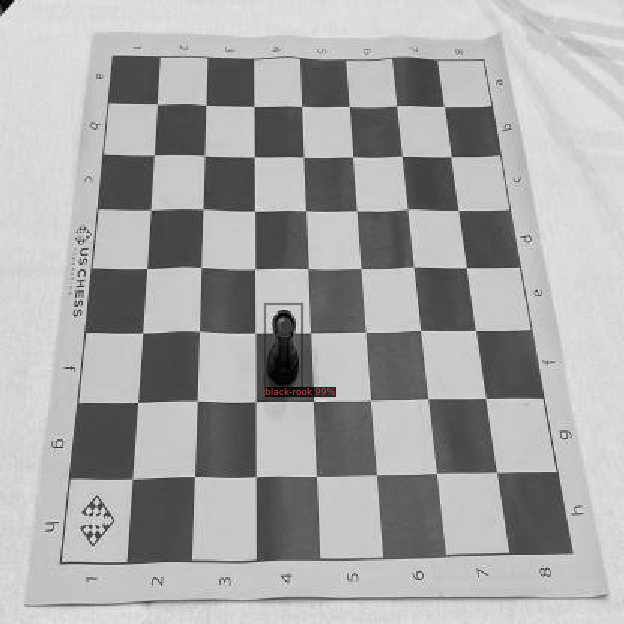

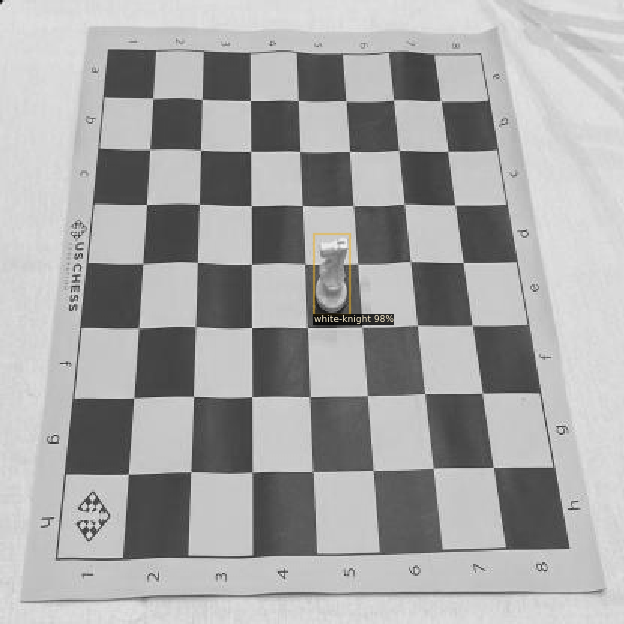

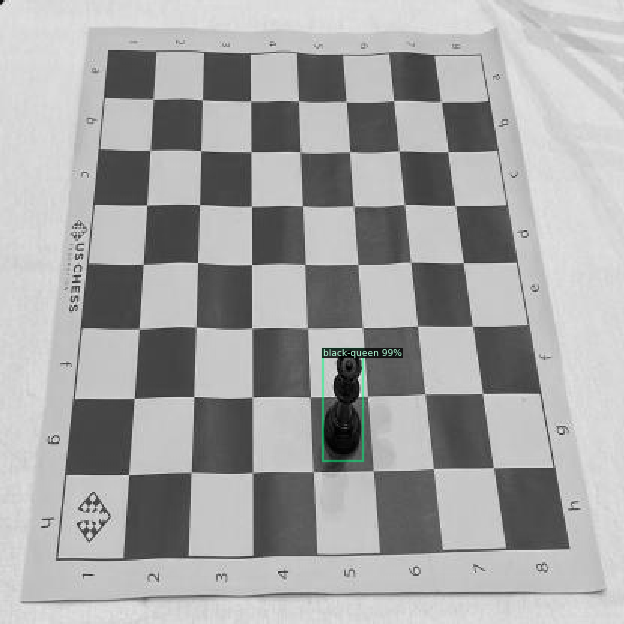

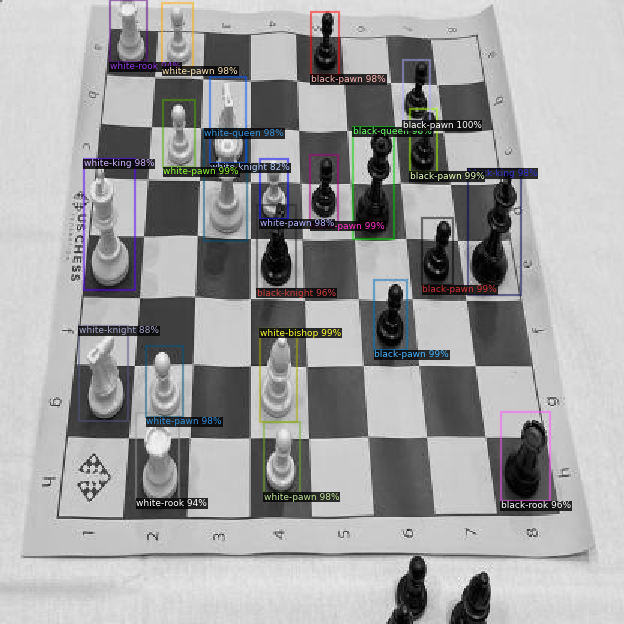

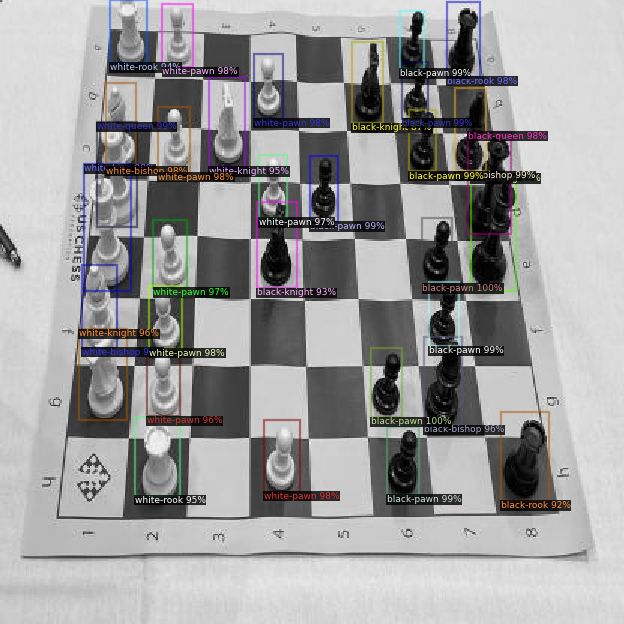

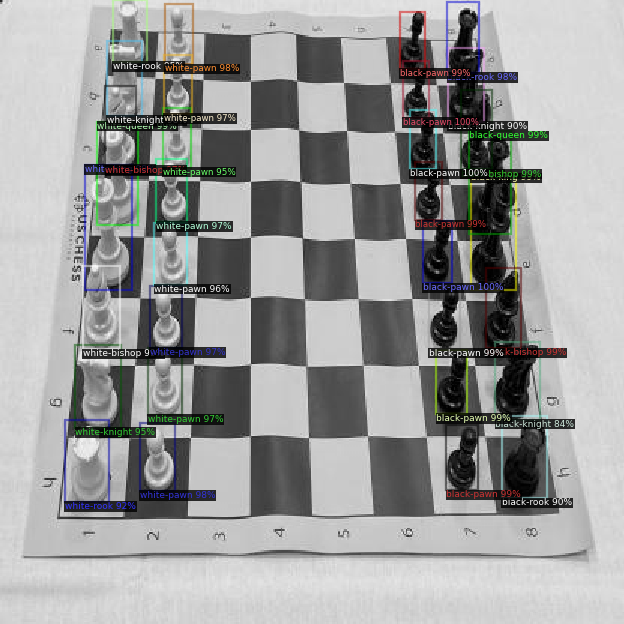

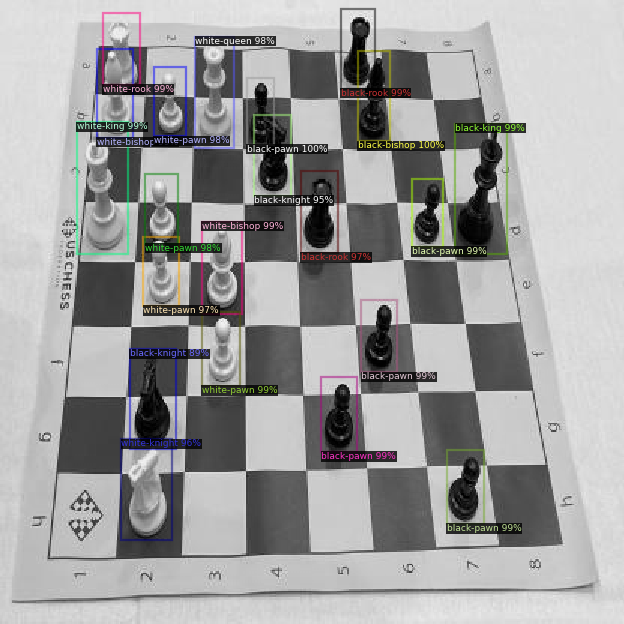

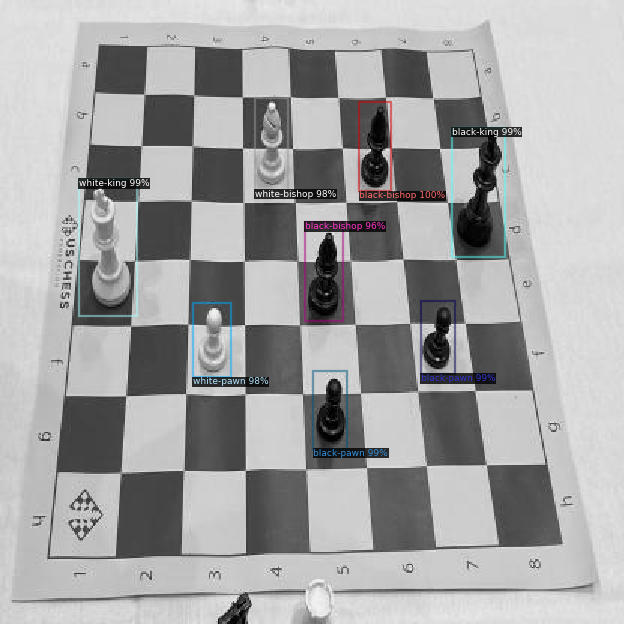

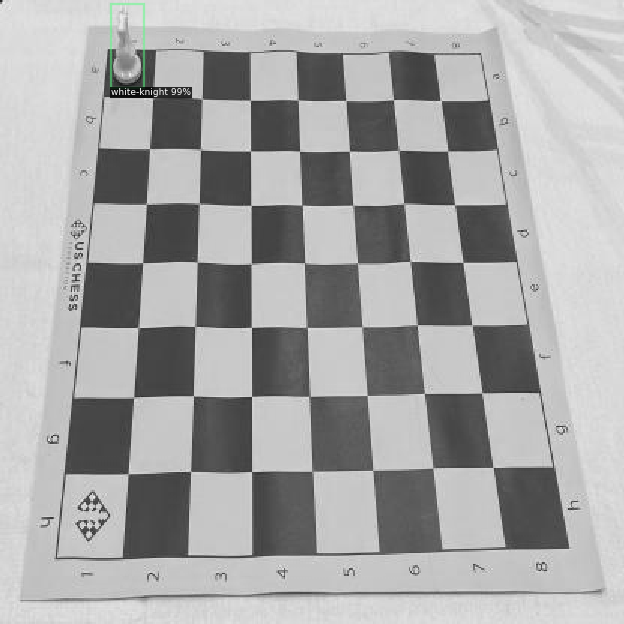

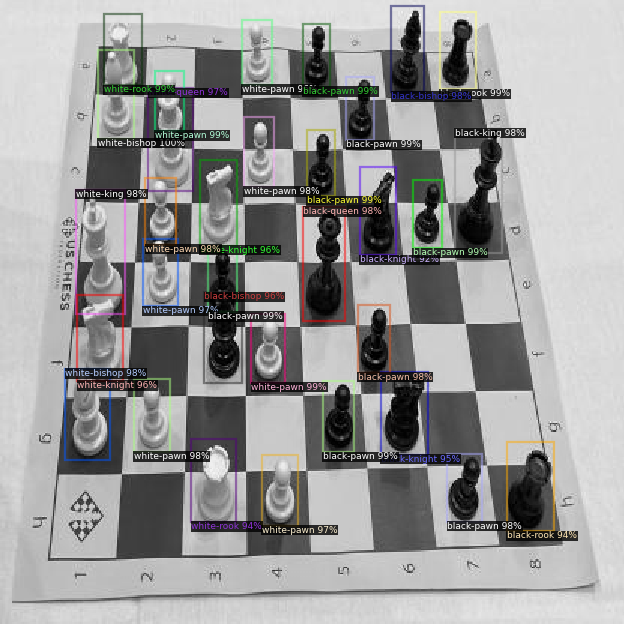

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Saving configure file

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

# Evaluating the model on test set

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator('customtest1', output_dir = "./output")
val_loader = build_detection_test_loader(cfg, 'customtest1')

print(inference_on_dataset(predictor.model,val_loader, evaluator))

WARNING [11/01 06:14:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/01 06:14:15 d2.data.datasets.coco]: Loaded 29 images in COCO format from /content/drive/MyDrive/Colab_Notebooks/detectron2/Chess Pieces.v24-416x416_aug.coco/test_annotations.coco.json
[11/01 06:14:15 d2.data.build]: Distribution of instances among all 14 categories:
|  category   | #instances   |   category   | #instances   |   category   | #instances   |
|:-----------:|:-------------|:------------:|:-------------|:------------:|:-------------|
|   pieces    | 0            |    bishop    | 0            | black-bishop | 21           |
| black-king  | 17           | black-knight | 25           |  black-pawn  | 86           |
| black-queen | 14           |  black-rook  | 26           | white-bishop | 25           |
| white-king  | 15           | white-knight | 25           |  white-pawn  | 88           |
| white-queen | 14           |  white-rook  |